# Perturbation Prediction with TRVAE

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches as sca
import numpy as np
import gdown
from scipy.sparse import issparse
import numpy as np
import pandas as pd
from matplotlib import pyplot
from scipy import stats
from scarches.models.trvae._utils import reg_mean_plot

 captum (see https://github.com/pytorch/captum).


In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Set relevant anndata.obs labels and training options

In [4]:
condition_key = 'condition'
cell_type_key = 'cell_label'

trvae_epochs = 2000

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 750,
    "reduce_lr": False
}

### Download Dataset and Preprocess

In [27]:
url = "https://drive.google.com/uc?id=1v3-ZmktCS61-oe2v1VtHtIhCeQl78SCN"
output = 'haber_count.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1v3-ZmktCS61-oe2v1VtHtIhCeQl78SCN
To: /Users/chelseaalexandra.bright/Downloads/haber_count.h5ad
100%|██████████| 34.6M/34.6M [00:01<00:00, 34.6MB/s]


'haber_count.h5ad'

In [6]:
adata = sc.read("haber_count.h5ad")

In [7]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="condition",
    subset=True)

In [8]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


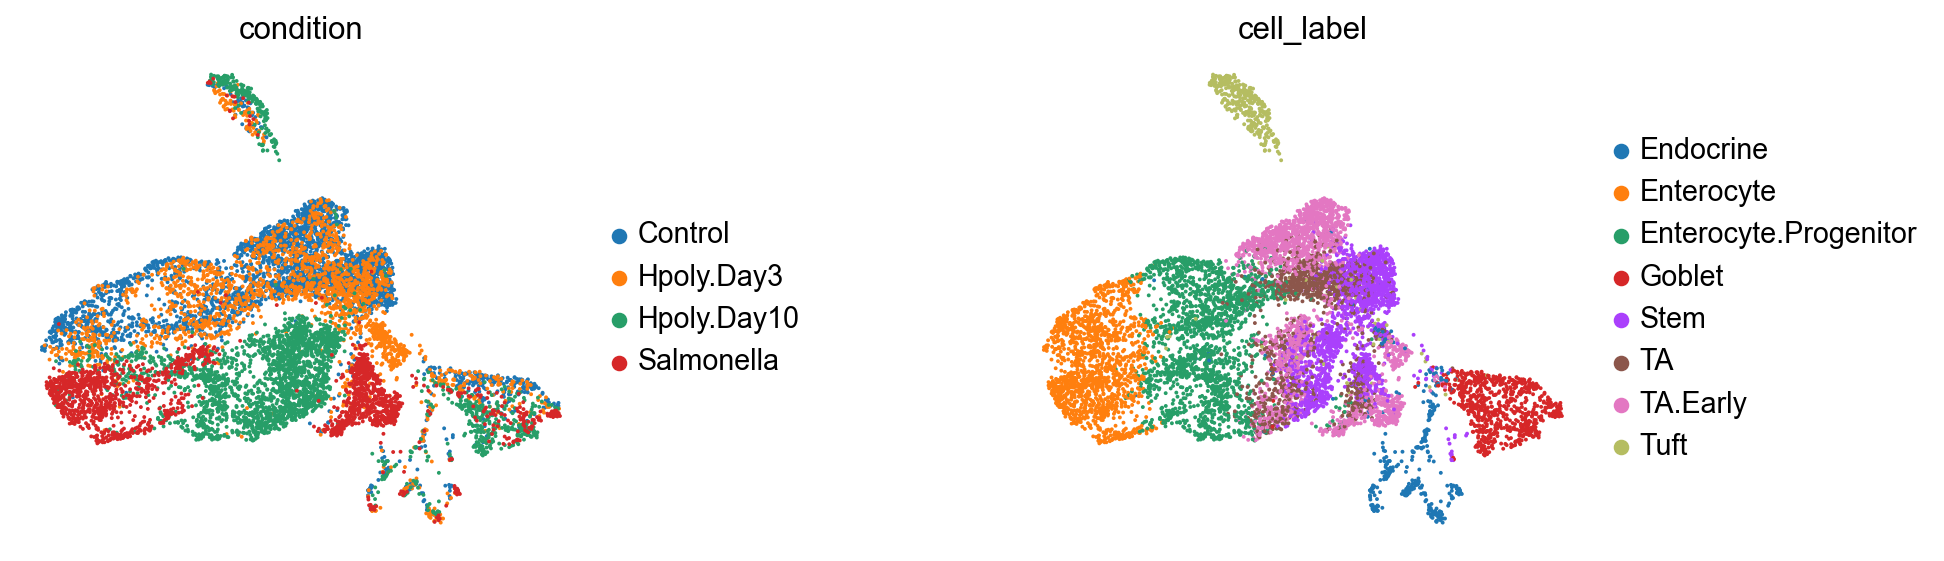

In [9]:
sc.pl.umap(adata, color=[condition_key, cell_type_key], 
           wspace=0.6, 
           frameon=False)

In [10]:
adata.obs.groupby([cell_type_key, condition_key]).size()

cell_label             condition  
Endocrine              Control        112
                       Hpoly.Day3     117
                       Hpoly.Day10     82
                       Salmonella      69
Enterocyte             Control        424
                       Hpoly.Day3     201
                       Hpoly.Day10    128
                       Salmonella     705
Enterocyte.Progenitor  Control        545
                       Hpoly.Day3     462
                       Hpoly.Day10    586
                       Salmonella     229
Goblet                 Control        216
                       Hpoly.Day3      99
                       Hpoly.Day10    317
                       Salmonella     126
Stem                   Control        670
                       Hpoly.Day3     388
                       Hpoly.Day10    592
                       Salmonella     207
TA                     Control        421
                       Hpoly.Day3     302
                       Hpoly.Day10    353

In [11]:
conditions = ['Control', 'Hpoly.Day3', 'Hpoly.Day10', 'Salmonella']
target_conditions = ["Hpoly.Day3", "Hpoly.Day10", "Salmonella"]
specific_celltype = "Tuft"

In [12]:
train_adata = adata[~((adata.obs[cell_type_key] == specific_celltype) & (adata.obs[condition_key].isin(target_conditions)))]

### Create TRVAE model and train it on dataset

Create the trVAE model instance with "recon_loss='mse'". Insert "recon_loss='nb'", or "recon_loss='zinb'", to change the reconstruction loss.

In [13]:
trvae = sca.models.TRVAE(
    adata=train_adata,
    condition_key=condition_key,
    conditions=conditions,
    hidden_layer_sizes=[128, 128],
    recon_loss="mse",
    dr_rate=0.2,
    use_bn=True
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 2000 128 4
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 4
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 



In [14]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    batch_size=512,
    clip_value=100,   
)

Preparing (9493, 2000)
Instantiating dataset
 |███████-------------| 36.4%  - val_loss: 99.1727371216 - val_recon_loss: 90.9784545898 - val_kl_loss: 6.0454294682 - val_mmd_loss: 2.148848533600
Stopping early: no improvement of more than 0 nats in 750 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 1066


### Create anndata file of latent representation and compute UMAP

In [15]:
adata_latent = sc.AnnData(trvae.get_latent())
adata_latent.obs['cell_label'] = train_adata.obs[cell_type_key].tolist()
adata_latent.obs['condition'] = train_adata.obs[condition_key].tolist()

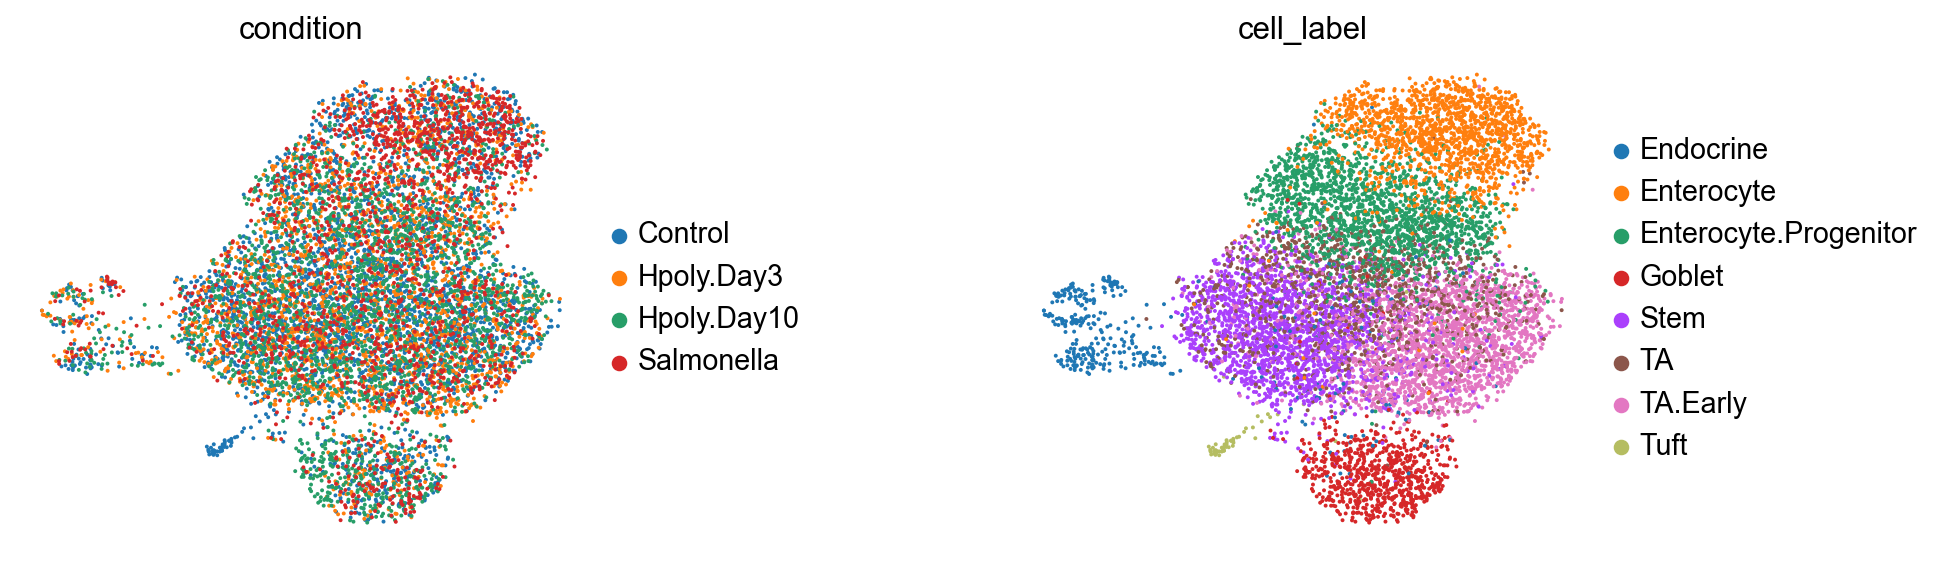

In [16]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['condition', 'cell_label'],
           frameon=False,
           wspace=0.6,
           )

### Get corrected gene expression data

Predict "Hpoly.Day10" Tuft cell states from "Control" Tuft cell states

In [17]:
cell_type_adata = train_adata[train_adata.obs[cell_type_key] == specific_celltype]

In [18]:
def get_reconstruction(model, x, encoder_labels=None, decoder_labels = None):

    x_ = torch.log(1 + x)
    if model.model.recon_loss == 'mse':
        x_ = x
    
    z_mean, z_log_var = model.model.encoder(x_, encoder_labels)
    latent = model.model.sampling(z_mean, z_log_var)
    output = model.model.decoder(latent, decoder_labels)
    return output[0]

In [19]:
def perturbation_prediction(model, adata, source_cond, target_cond):

        device = next(model.model.parameters()).device

        source_adata = adata[adata.obs[condition_key] == source_cond]

        from scarches.dataset.trvae._utils import label_encoder
        encoder_labels = label_encoder(source_adata, model.model.condition_encoder, condition_key)
        decoder_labels = np.zeros_like(encoder_labels) + model.model.condition_encoder[target_cond]

        x = adata.X

        latents = []
        indices = torch.arange(x.shape[0])
        subsampled_indices = indices.split(512)
        for batch in subsampled_indices:
                x_batch = x[batch, :]
                if issparse(x_batch):
                        x_batch = x_batch.toarray()
                x_batch = torch.tensor(x_batch, device=device)
                encoder_labels = torch.tensor(encoder_labels, device=device)
                decoder_labels = torch.tensor(decoder_labels, device=device)
                latent = get_reconstruction(model, x_batch, encoder_labels[batch], decoder_labels[batch])
                latents += [latent.cpu().detach()]

        return np.array(torch.cat(latents))

In [20]:
corrected_data = perturbation_prediction(trvae, cell_type_adata, "Control", "Hpoly.Day10")

In [21]:
corrected_adata = cell_type_adata[cell_type_adata.obs[condition_key] == "Control"].copy()
corrected_adata.X = corrected_data
corrected_adata.obs['condition'] = 'pred'

### Evaluation of the prediction

In [22]:
target_cell_adata = adata[adata.obs[cell_type_key] ==specific_celltype]

In [23]:
sc.tl.rank_genes_groups(target_cell_adata, groupby="condition", method="wilcoxon")
diff_genes = target_cell_adata.uns["rank_genes_groups"]["names"]["Hpoly.Day10"]
print(diff_genes)

['Defa24' 'Gm15284' 'Defa22' 'Defa17' 'Spink4' 'AY761184' 'Lyz1' ...
 'Zg16' 'Sepp1' 'Guca2b' 'Gip' 'Fabp6' 'Apoa1' 'Fabp2']


In [25]:
dis_adata = adata[(adata.obs[cell_type_key] == specific_celltype) & (adata.obs[condition_key] == 'Hpoly.Day10')]
eval_adata = dis_adata.concatenate(corrected_adata)

Compare trVAE-predicted and real infected Tuft cells mean expression with the top 10 differentially expressed genes highlighted in red

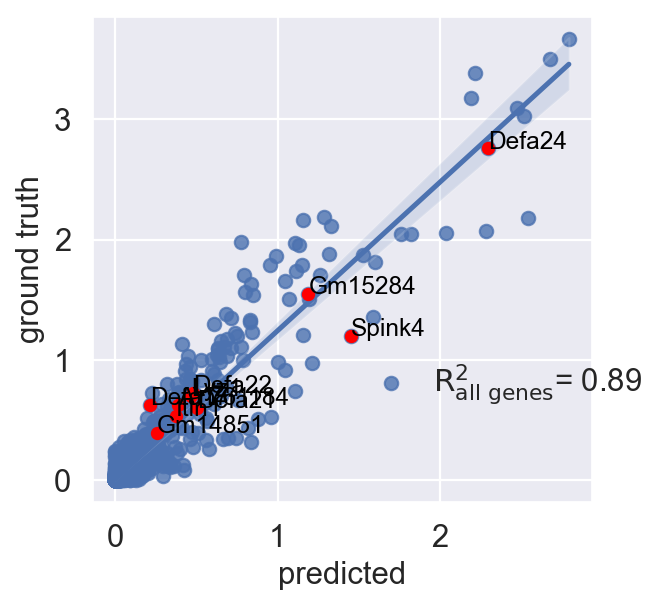

In [26]:
r2_value = reg_mean_plot(
    eval_adata,
    condition_key="condition",
    target_condition="Hpoly.Day10",
    gene_list=diff_genes[:10],
    labels={"x": "predicted", "y": "ground truth"},
    show=True,
    legend=False
)